In [1]:
import matplotlib.pyplot as plt
from imageio import imread
%matplotlib inline

import imageio

from glob import glob
import numpy as np
from tqdm import tqdm

from PoisDenoiser.utils import get_poisson_pair_by_maxval
from PoisDenoiser.utils import show_images as show
from skimage.transform import resize

import torch as th

def RandomCrop(img, size):
    rand_y = np.random.randint(0, img.shape[0]-size)
    rand_x = np.random.randint(0, img.shape[1]-size)
    img = img[rand_y:rand_y+size, rand_x:rand_x+size]
    return img

In [2]:
# new_folders = ['train', 'val']

new_dataset_path = './DATASETS/BSDS500/BSDS500_validation_MAXVALs_01_2/'
orig_dataset_path = './../Denoising/Diploma/DATASETS/BSDS500/BSDS500_original/'

size = 128

In [3]:
# prepare orig train files' paths

imgs_pairs_PathsNames_train = []
for folder in ['train', 'test']:
    folder_path = orig_dataset_path+folder+'/'
    imgs_paths = glob(folder_path+'*.jpg')
    imgs_pairs_PathsNames = [{'path':img_path, 'name':img_path[len(folder_path):-4]} \
                                                                 for img_path in imgs_paths]   
    imgs_pairs_PathsNames_train.extend(imgs_pairs_PathsNames)
    
# prepare orig val files' paths

folder_path = orig_dataset_path+'val/'
imgs_val_paths = glob(folder_path+'*.jpg')
imgs_pairs_PathsNames_val = [{'path':img_path, 'name':img_path[len(folder_path):-4]} \
                                                                 for img_path in imgs_val_paths]   
   
pairs = {'train':imgs_pairs_PathsNames_train, \
         'val':imgs_pairs_PathsNames_val}

In [21]:
maxval_linspace = np.linspace(0.1, 2, num=20)

np.random.seed(1)
for folder_type in ['train', 'val']: 
    
    if folder_type == 'train':
        continue
        
    num_crops = 4 if folder_type == 'train' else 1
     
    list_of_pairs = []
    for i in range(num_crops):
        tmp_pairs = pairs[folder_type].copy()
        np.random.shuffle(tmp_pairs)
        list_of_pairs.extend(tmp_pairs)
    
    len_pairs, len_maxvals = len(list_of_pairs), len(maxval_linspace)
    num_periods, residual = len_pairs//len_maxvals, len_pairs%len_maxvals
    
    if residual == 0:
        list_of_maxvals = (list(maxval_linspace)*(num_periods))
    else:
        list_of_maxvals = (list(maxval_linspace)*(num_periods + 1))[:-(len_maxvals-residual)]
        
    for i, (pair, max_val) in enumerate(tqdm(zip(list_of_pairs, list_of_maxvals))):
        cur_crop_ind = int(i/len(list_of_pairs)*num_crops) + 1
        path, name = pair['path'], pair['name']
        gt = imread(path).astype(np.float32)
        gt = (gt[...,0] + gt[...,1] + gt[...,2])/3
        gt[gt < 1] = 1
        gt /= 255
#         gt = RandomCrop(gt, size)
        gt, noisy = get_poisson_pair_by_maxval(gt, max_val)
        gt.unsqueeze_(0)
        noisy.unsqueeze_(0)
        
        
        save_path = new_dataset_path#folder_type+'/'

        val = '{:02.0f}'.format(int(max_val*10))
        val1, val2 = val[0], val[1]
        th.save(gt, save_path+'gt/'+name+'_{}_maxval={}dot{}.pth'\
                .format(cur_crop_ind, val1, val2))
        th.save(noisy, save_path+'noisy/'+name+'_{}_maxval={}dot{}.pth'\
                .format(cur_crop_ind, val1, val2))


100it [00:02, 49.91it/s]


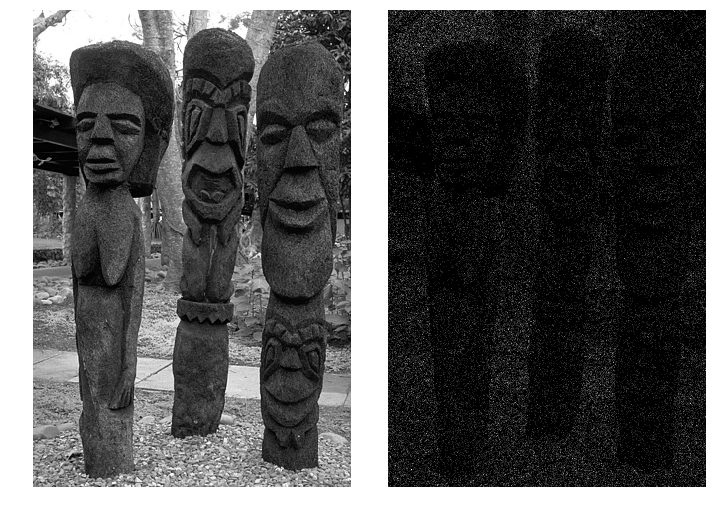

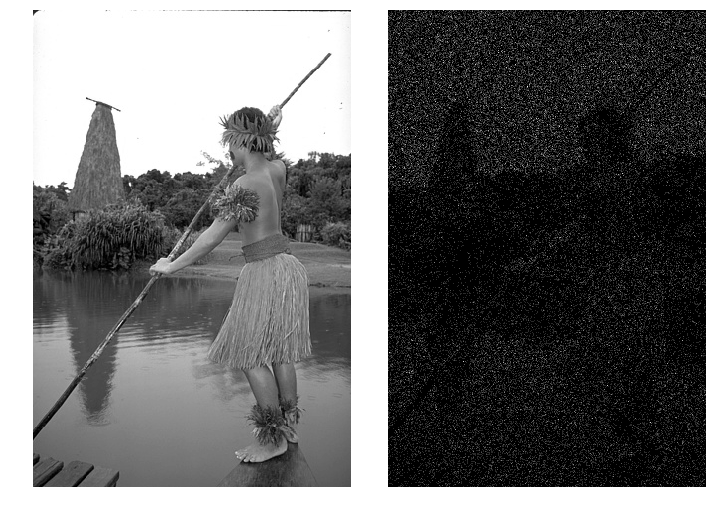

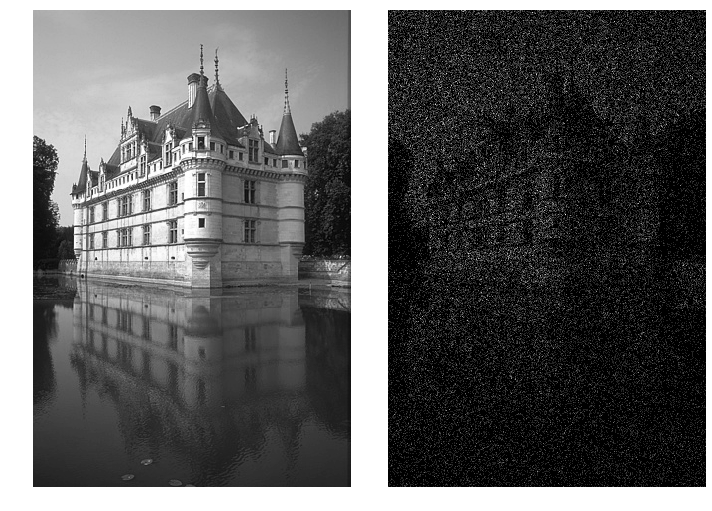

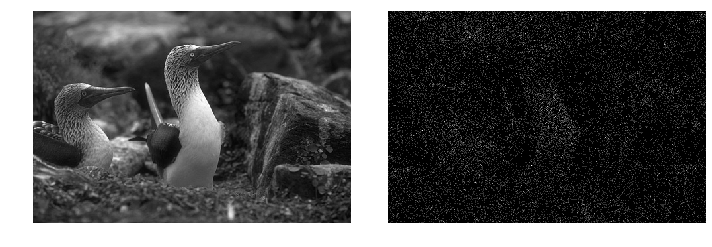

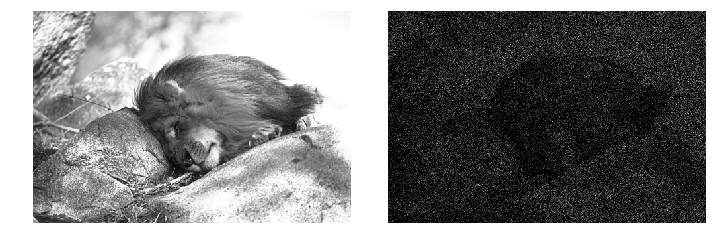

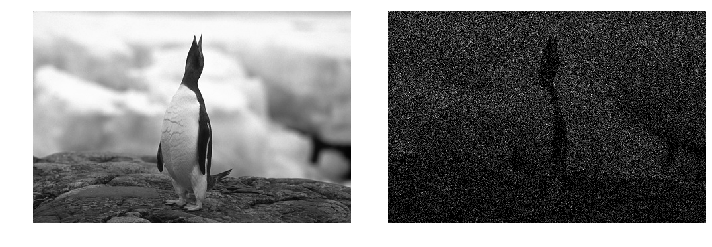

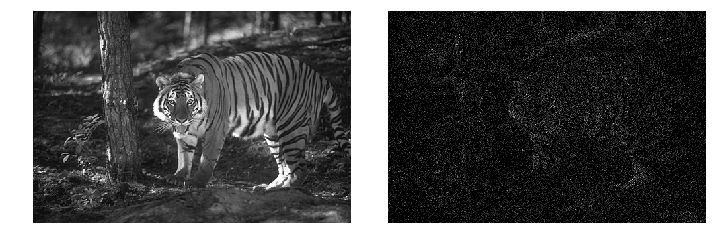

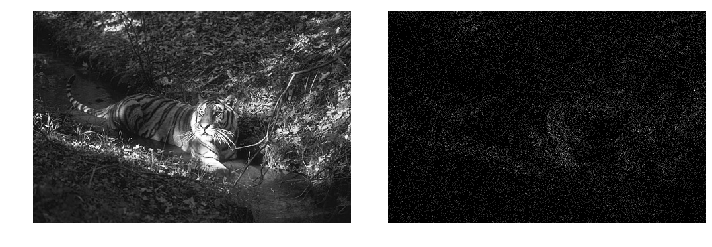

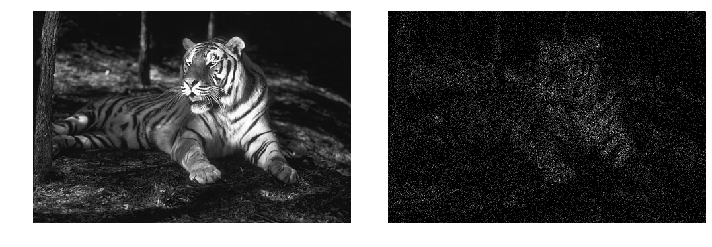

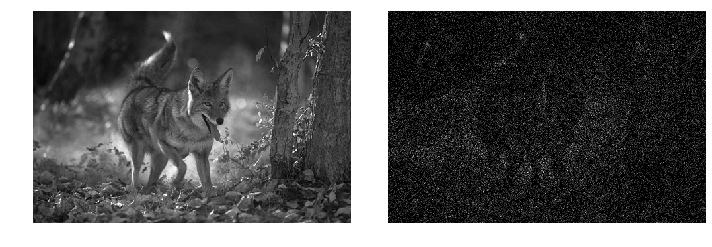

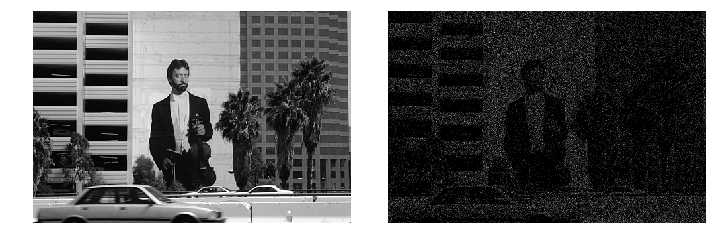

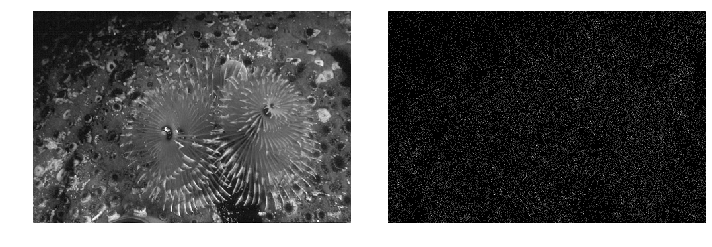

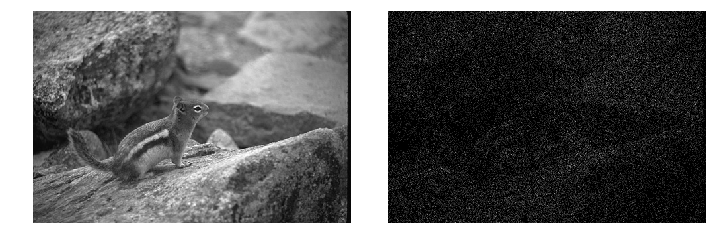

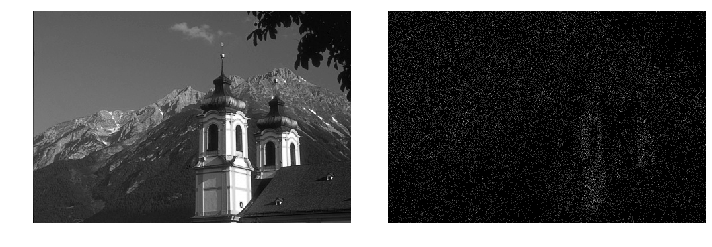

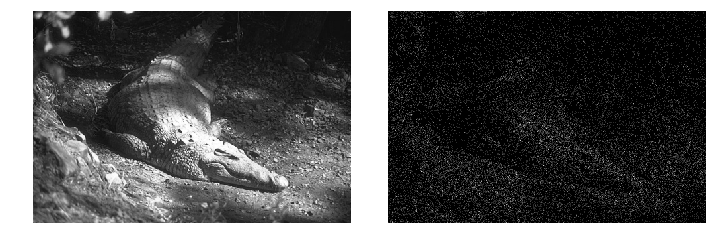

In [5]:
path2folder = './DATASETS/BSDS500/BSDS500_validation_MAXVALs_01_2/val/'
names = sorted([name[len(path2folder)+3:-4] for name in glob(path2folder+'gt/*.pth')])
for name in names[:15]:
    clear = th.load(path2folder+'gt/'+name+'.pth')[0]
    noisy = th.load(path2folder+'noisy/'+name+'.pth')[0]
    clear.unsqueeze_(0)
    noisy.unsqueeze_(0)
    show([clear, noisy])
    

In [16]:
clear, clear.max(), clear.min()

(tensor([[0.5982, 0.6241, 0.6111,  ..., 0.6097, 0.5967, 0.5162],
         [0.5809, 0.5852, 0.5723,  ..., 0.6111, 0.6068, 0.5637],
         [0.5967, 0.5881, 0.5795,  ..., 0.6025, 0.6025, 0.6068],
         ...,
         [0.3336, 0.3207, 0.2991,  ..., 0.4443, 0.4486, 0.4544],
         [0.1999, 0.2732, 0.3120,  ..., 0.4400, 0.4529, 0.4127],
         [0.0618, 0.1136, 0.1912,  ..., 0.4371, 0.4041, 0.2732]]),
 tensor(0.7621),
 tensor(0.0043))

In [17]:
noisy, noisy.max(), noisy.min()

(tensor([[0., 1., 1.,  ..., 1., 1., 0.],
         [0., 1., 0.,  ..., 2., 0., 0.],
         [2., 0., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 0., 1.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 1., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.]]), tensor(6.), tensor(0.))